Creating directory: ./results/sim_2025_11_13_923144
Number of EVs: 20
Number of ports: 25
Simulation length: 112
Time scale: 0.25
Prediction horizon: 112
Initial SoC: [50.5        47.93290051 36.88072375 27.46629924 56.8        48.50151855 38.88076362 42.97016405 50.5        51.19753172 31.69106115 30.2125126  19.52130601 38.01170133 51.45761023 43.42325871 44.17237434 23.65061981 43.73478604 38.44214787]
Final SoC: [57.5 58.  57.5 46.3 64.8 64.8 64.8 57.5 57.5 57.5 57.5 46.3 46.3 57.5 57.5 58.  57.5 46.3 57.5 58. ]
Arrival times: [11 11 12 13 13 13 14 15 15 15 18 18 19 20 23 23 29 30 34 40]
Departure times: [52 45 55 51 41 44 48 39 57 48 52 46 50 51 41 40 52 51 51 55]
Initial conditions: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Final conditions: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

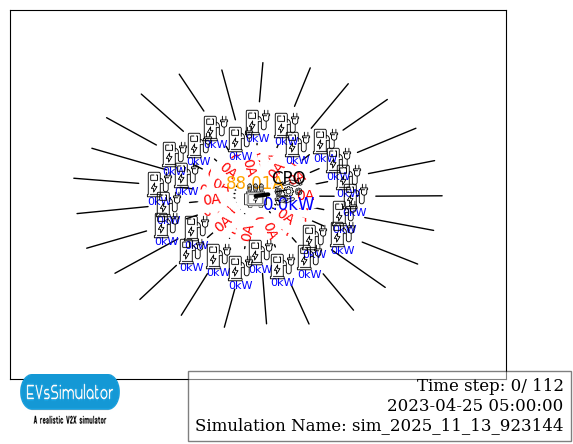

In [22]:
from ev2gym.models.ev2gym_env import EV2Gym
from ev2gym.baselines.mpc.V2GProfitMax import V2GProfitMaxOracle
from ev2gym.baselines.heuristics import ChargeAsFastAsPossible

import os
os.chdir("/home/helen/EV2Gym")

# we will use an example configuration file
notebook_dir = os.path.dirname(os.path.abspath("/home/helen/EV2Gym/tutorials/CreateYourCustomRLAlgorithm.ipynb"))
config_file = os.path.abspath(os.path.join(notebook_dir, "..", "ev2gym", "example_config_files", "V2GProfitPlusLoads.yaml"))
ev_specs_file = os.path.abspath(os.path.join(notebook_dir, "..", "ev2gym", "data", "ev_specs_ev_plus_phev.json"))

# config_file = "ev2gym/example_config_files/V2GProfitPlusLoads.yaml"

# Initialize the environment
env = EV2Gym(config_file=config_file,
              render_mode=True,
              save_replay=True,
              save_plots=True)
state, _ = env.reset()
agent = V2GProfitMaxOracle(env,verbose=True) # optimal solution
#        or 
# agent = ChargeAsFastAsPossible(verbose = True) # heuristic
for t in range(env.simulation_length):
    actions = agent.get_action(env) # get action from the agent/ algorithm
    new_state, reward, done, truncated, stats = env.step(actions)  # takes action


In [20]:
state, _ = env.reset()
actions = agent.get_action(env)
len(actions)
new_state, reward, done, truncated, stats = env.step(actions)
new_state

AttributeError: 'NoneType' object has no attribute 'render'

In [15]:
new_state

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a list of states and actions collected during simulation
# Example: states = [state1, state2, ...], actions = [action1, action2, ...]

# Convert states and actions to DataFrames for easier plotting
df_states = pd.DataFrame(states)
df_actions = pd.DataFrame(actions)

# Plot selected state variables (e.g., columns 0, 1, 2)
plt.figure(figsize=(12, 6))
df_states[[0, 1, 2]].plot()
plt.title("Selected State Variables Over Time")
plt.xlabel("Timestep")
plt.ylabel("State Value")
plt.legend(["State 0", "State 1", "State 2"])
plt.show()

# Plot actions for each port
plt.figure(figsize=(12, 6))
df_actions.plot()
plt.title("Actions Over Time (per port)")
plt.xlabel("Timestep")
plt.ylabel("Action Value")
plt.legend([f"Port {i}" for i in range(df_actions.shape[1])])
plt.show()

NameError: name 'states' is not defined

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from sb3_contrib import TQC, TRPO, ARS, RecurrentPPO

from ev2gym.models.ev2gym_env import EV2Gym
# Choose a default reward function and state function or create your own!!!
from ev2gym.rl_agent.reward import profit_maximization, SquaredTrackingErrorReward, ProfitMax_TrPenalty_UserIncentives
from ev2gym.rl_agent.state import V2G_profit_max, PublicPST, V2G_profit_max_loads

reward_function = profit_maximization
state_function = PublicPST

config_file = "ev2gym/example_config_files/PublicPST.yaml"
env = gym.make('EV2Gym-v1',
                config_file=config_file,
                reward_function=reward_function,
                state_function=state_function)
# Initialize the RL agent
model = DDPG("MlpPolicy", env)
# Train the agent
model.learn(total_timesteps=10000,
            progress_bar=True)
# Evaluate the agent
env = model.get_env()
obs = env.reset()
stats = []
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    if done:
        stats.append(info)

/home/helen/venvs/e2v_env/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.26GB > 0.47GB
  warnings.warn(


Output()

In [3]:
stats 

[[{'total_ev_served': np.int64(16),
   'total_profits': np.float64(47.57623567530651),
   'total_energy_charged': np.float64(192.93043760853882),
   'total_energy_discharged': np.float64(410.52405841906454),
   'average_user_satisfaction': np.float64(0.4762473658985589),
   'power_tracker_violation': np.float64(94.12254178420415),
   'tracking_error': np.float64(37567.68990257768),
   'energy_tracking_error': np.float64(264.6548917026279),
   'energy_user_satisfaction': np.float64(47.62473658985589),
   'std_energy_user_satisfaction': np.float64(41.89662630240078),
   'min_energy_user_satisfaction': np.float64(8.620689655172415),
   'total_steps_min_emergency_battery_capacity_violation': 9,
   'total_transformer_overload': np.float64(0.0),
   'battery_degradation': np.float64(0.0011655301022258854),
   'battery_degradation_calendar': np.float64(0.00022321262619916468),
   'battery_degradation_cycling': np.float64(0.0009423174760267209),
   'total_reward': np.float64(-280.20479837708757

array([<Axes: >, <Axes: >], dtype=object)

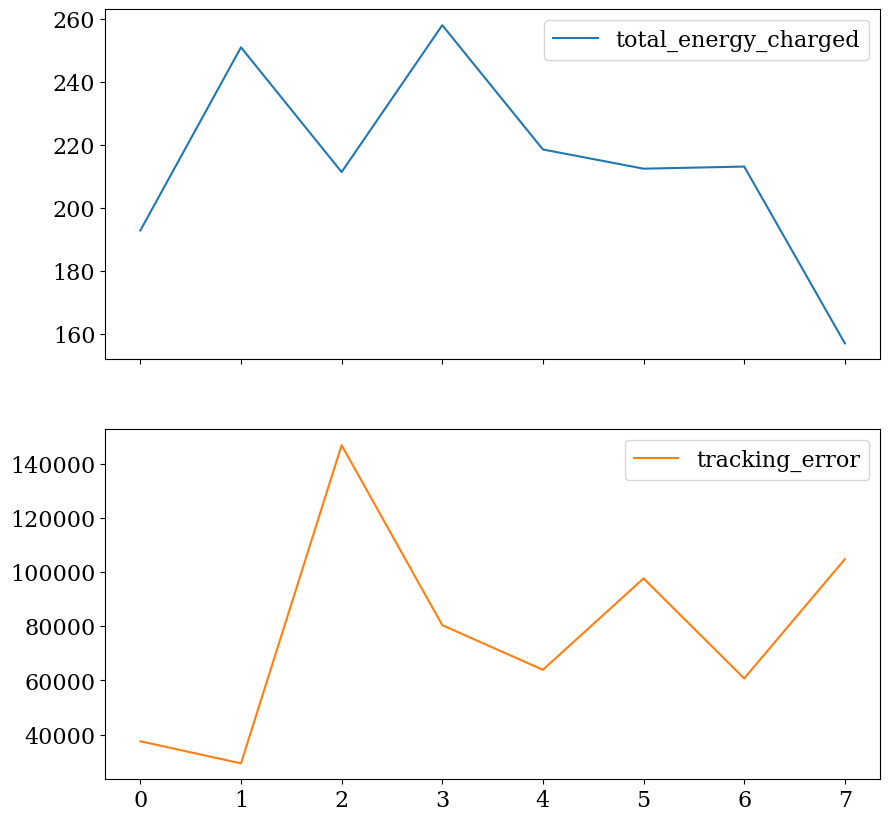

In [10]:
#plot episode stats
import pandas as pd
import numpy as np

# Flatten the list of lists
flat_stats = [item for sublist in stats for item in sublist]

# Convert numpy types to native Python types and arrays to lists
def clean_dict(d):
    clean = {}
    for k, v in d.items():
        if isinstance(v, np.ndarray):
            clean[k] = v.tolist()
        elif isinstance(v, (np.generic,)):
            clean[k] = v.item()
        else:
            clean[k] = v
    return clean

cleaned_stats = [clean_dict(d) for d in flat_stats]
df_stats = pd.DataFrame(cleaned_stats)

episode_stats = df_stats
#Select only the columns we want to plot
episode_stats = episode_stats[['total_energy_charged','tracking_error']]

#plot
episode_stats.plot(subplots=True, figsize=(10,10))